In [1]:
%pip install yfinance numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf

tickers = ['SPY', 'QQQ',  'AAPL', 'MSFT']

stocks = {ticker: yf.Ticker(ticker).history(start='2010-01-01', end='2023-12-01') for ticker in tickers}

In [3]:
def drop_na() -> None:
    for stock in stocks.values():
        stock.dropna(inplace=True)

drop_na()

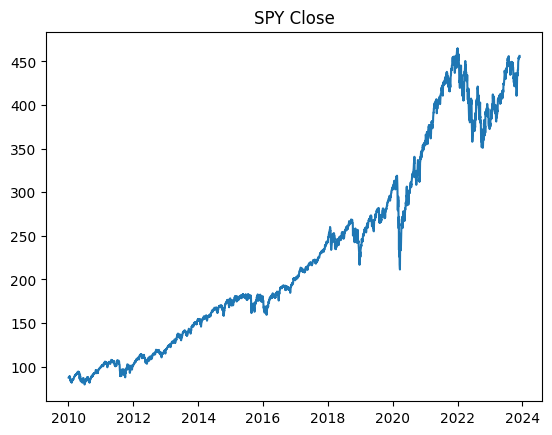

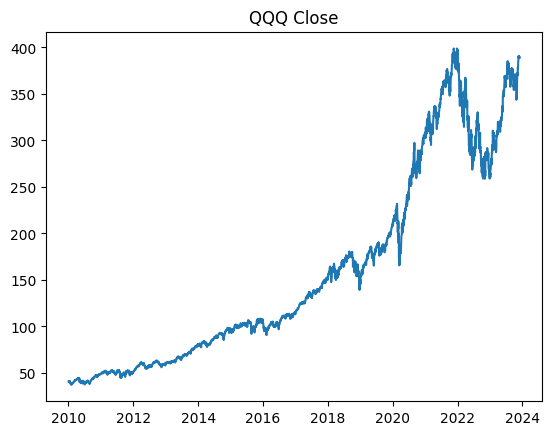

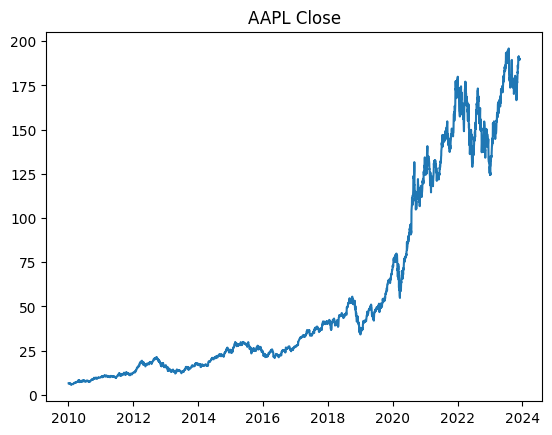

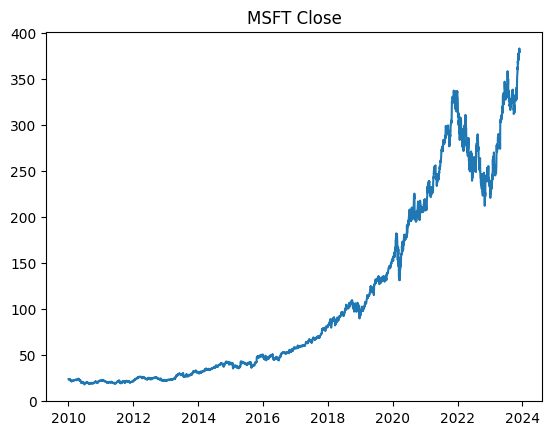

In [4]:
import matplotlib.pyplot as plt

def plot_col(col: str) -> None:
    for ticker, stock in stocks.items():
        plt.figure()
        plt.title(f'{ticker} {col}')
        plt.plot(stock[col])
        plt.show()

plot_col('Close')

In [5]:
def drop_cols(cols: list[str]) -> None:
    for stock in stocks.values():
        stock.drop(columns=[col for col in cols if col in stock.columns], inplace=True)

drop_cols(['Dividends', 'Stock Splits', 'Capital Gains', 'Volume'])

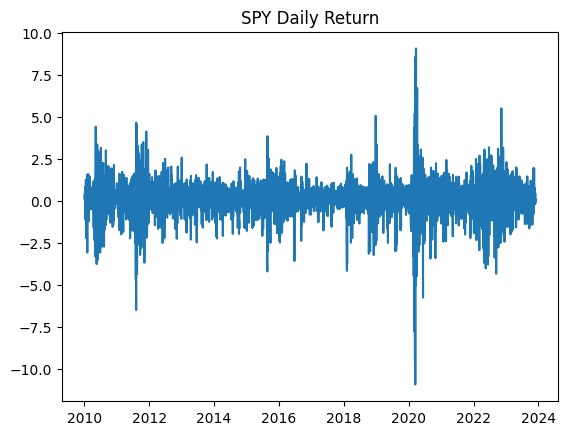

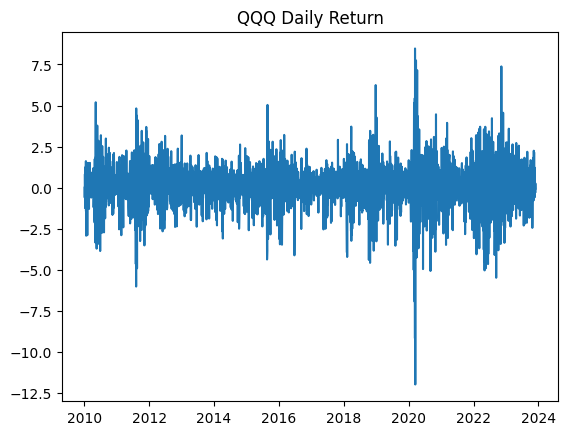

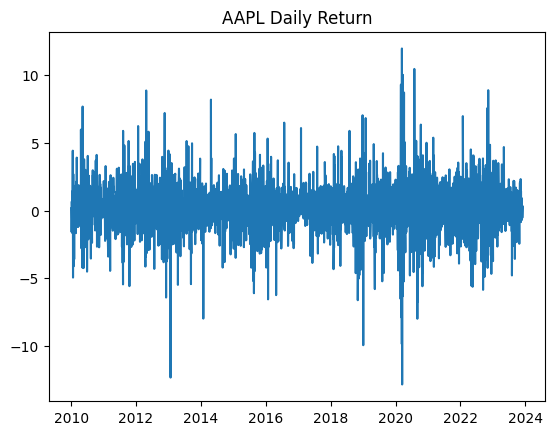

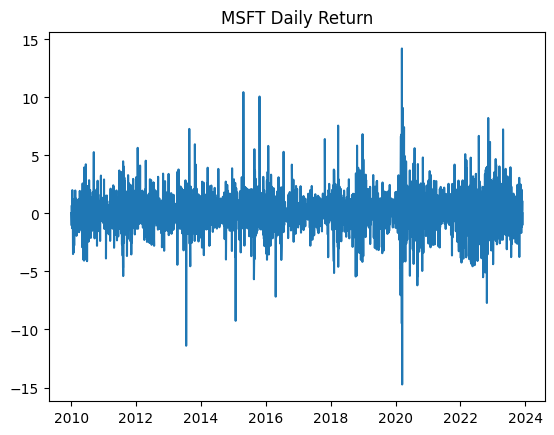

In [6]:
import numpy as np

for stock in stocks.values():
    stock['Daily Return'] = (stock['Close'] / stock['Close'].shift(1) - 1) * 100

drop_na()
    
plot_col('Daily Return')

In [7]:
def plot_lookback(col: str, lookback: list[int]) -> None:
    for ticker, stock in stocks.items():
        plt.figure()
        plt.title(f'{ticker} {col}')
        plt.plot(stock[[f'{n} {col}' for n in lookback]])
        plt.legend([f'{n} Day' for n in lookback])
        

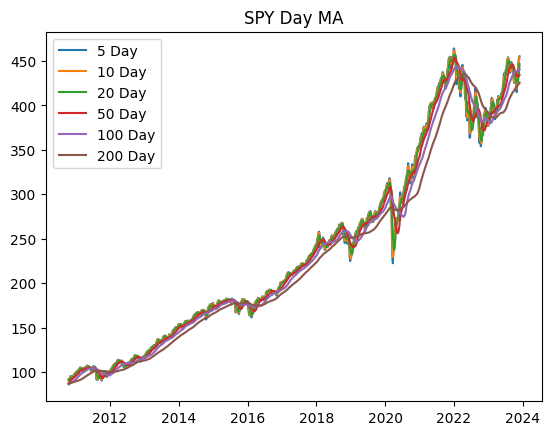

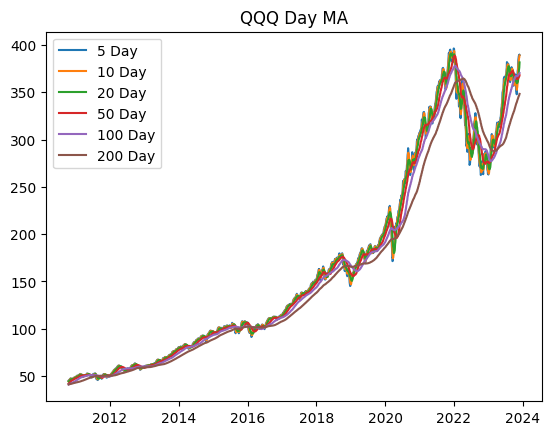

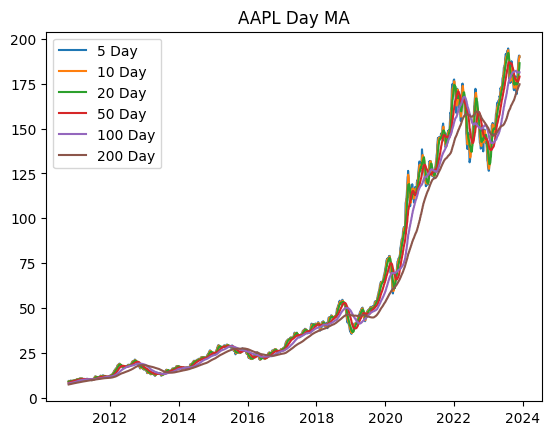

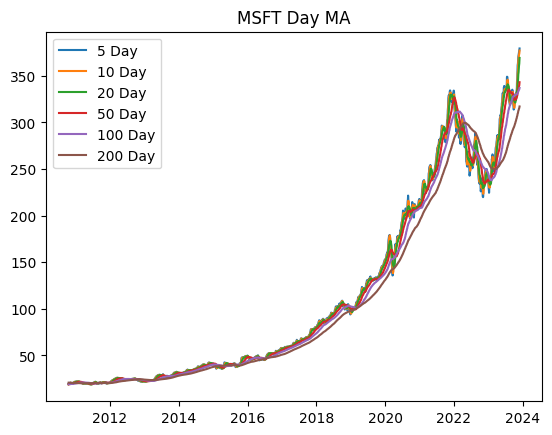

In [8]:
lookback = [5, 10, 20, 50, 100, 200]

for stock in stocks.values():
    for n in lookback:
        stock[f'{n} Day MA'] = stock['Close'].rolling(n).mean()

drop_na()
    
plot_lookback('Day MA', lookback)

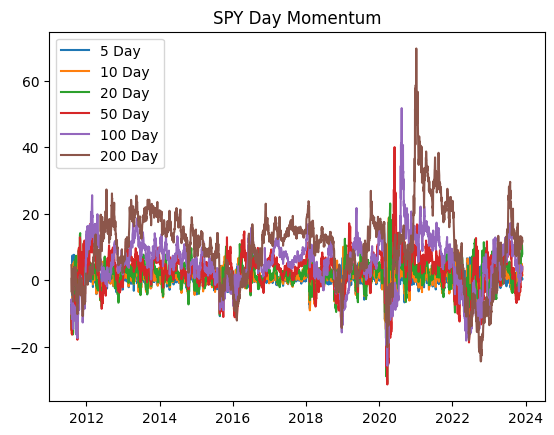

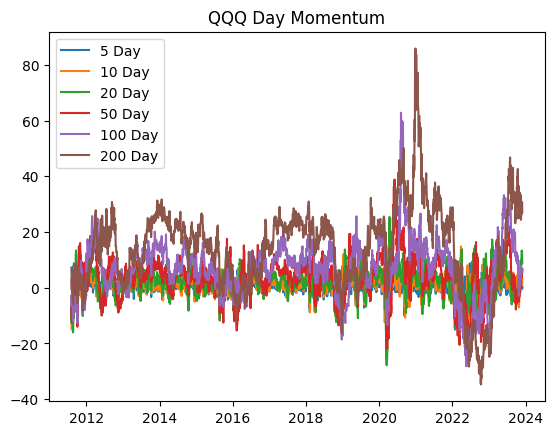

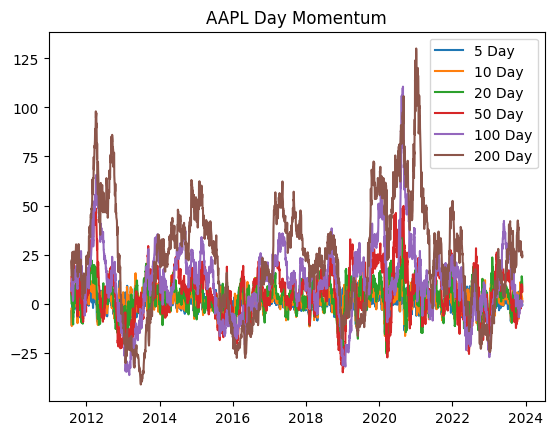

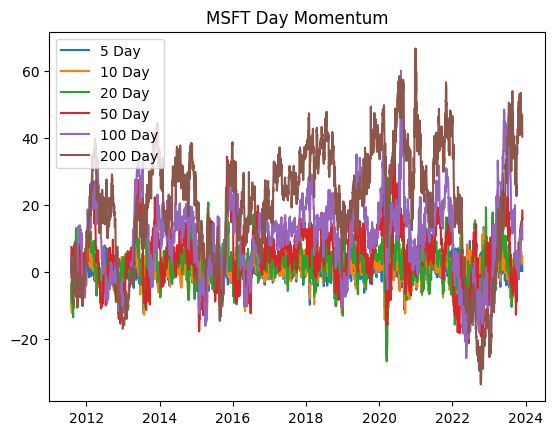

In [9]:
for stock in stocks.values():
    for n in lookback:
        stock[f'{n} Day Momentum'] = stock['Close'].pct_change(periods=n) * 100

drop_na()

        
plot_lookback('Day Momentum', lookback)

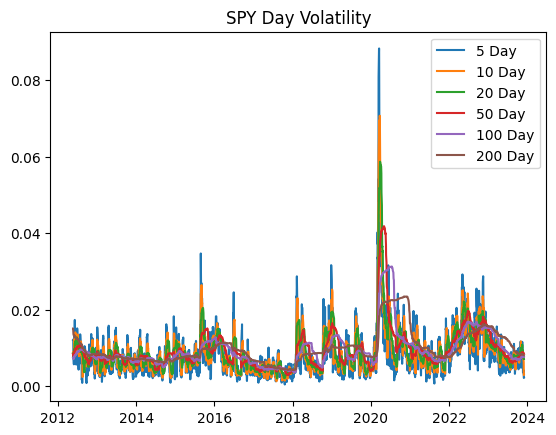

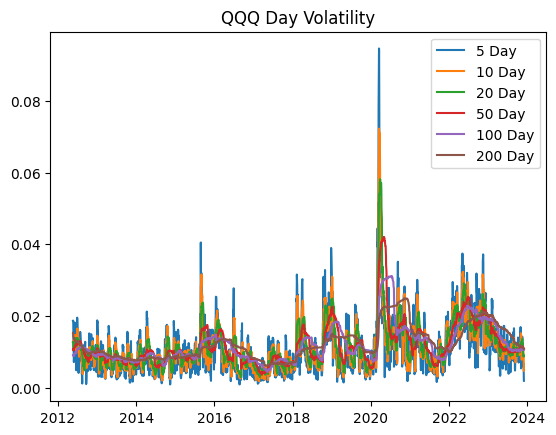

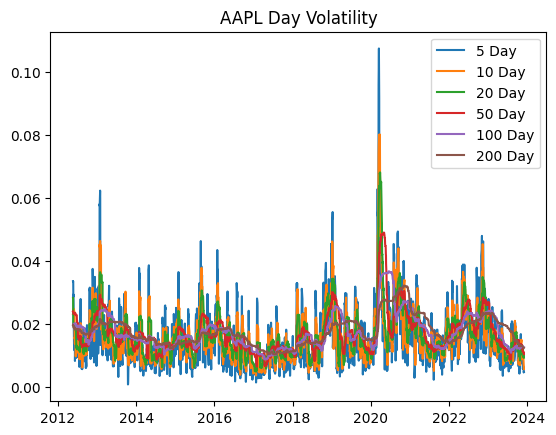

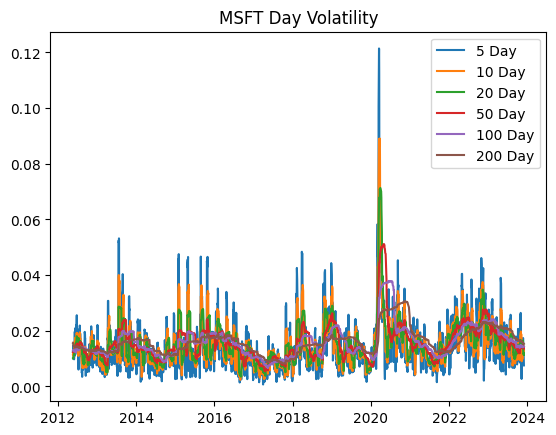

In [10]:
for stock in stocks.values():
    for n in lookback:
        stock[f'{n} Day Volatility'] = stock['Close'].pct_change().rolling(n).std()
        
drop_na()

plot_lookback('Day Volatility', lookback)

In [11]:
for stock in stocks.values():
    stock['Next Close'] = stock['Close'].shift(-1)

drop_na()

In [12]:
from copy import deepcopy

data_sets = {ticker: deepcopy(stock.iloc[:, :-1]) for ticker, stock in stocks.items()}

In [13]:
LOOKBACK_PERIODS = 30
train_test = {}

for ticker, data_set in stocks.items():
    X_processed = [data_set.iloc[time_index - LOOKBACK_PERIODS:time_index, feature_index] 
                   for feature_index in range(data_set.shape[1]) 
                   for time_index in range(LOOKBACK_PERIODS, data_set.shape[0])]

    X_array = np.array(X_processed).reshape(-1, LOOKBACK_PERIODS, data_set.shape[1]).transpose(0, 1, 2)

    y_array = np.array([data_set.iloc[time_index, -1] for time_index in range(LOOKBACK_PERIODS, data_set.shape[0])]).reshape(-1, 1)
    
    split_limit = int(len(X_array) * 0.90)
    X_train, X_test = X_array[:split_limit], X_array[split_limit:]
    y_train, y_test = y_array[:split_limit], y_array[split_limit:]
    
    train_test[ticker] = (X_train, X_test, y_train, y_test)


In [14]:
def scale(scaler) -> dict[str, tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]]:
    result = {}
    for ticker, (X_train, X_test, y_train, y_test) in train_test.items():
        num_samples, num_timesteps, num_features = X_train.shape
        
        X_train_reshaped = X_train.reshape(-1, num_features)
        X_test_reshaped = X_test.reshape(-1, num_features)

        X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)
        X_test_scaled_reshaped = scaler.transform(X_test_reshaped)

        X_train_scaled = X_train_scaled_reshaped.reshape(num_samples, num_timesteps, num_features)
        X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape[0], num_timesteps, num_features)
        
        result[ticker] = (X_train_scaled, X_test_scaled, y_train, y_test)
    return result

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_train_test = scale(scaler)

In [32]:
from keras.layers import LSTM, Dense, Dropout, Input, Activation
from keras import optimizers
from keras.models import Model
from keras.callbacks import LearningRateScheduler, EarlyStopping


def step_decay(epoch: int) -> float:
    return 1e-2 * np.power(5e-1, np.floor((epoch+1)/10.0))


def train(data_set: dict[str, tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]]) -> None:
    for ticker, data_set in data_set.items():
        X_train, X_test, y_train, y_test = data_set
        _, num_timesteps, num_features = X_train.shape

        
        lstm_input = Input(shape=(num_timesteps, num_features), name='lstm-input')
        x = LSTM(100, name='first_layer')(lstm_input) 
        x = Dropout(0.2)(x) 
        x = Dense(1, name='dense_layer')(x)
        output = Activation('linear', name='output')(x)

        model = Model(inputs=lstm_input, outputs=output)

        adam = optimizers.legacy.Adam()
        model.compile(optimizer=adam, loss='mse')

        lrate = LearningRateScheduler(step_decay)
        early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

        model.fit(x=X_train, y=y_train, batch_size=5, epochs=100, shuffle=True, 
                validation_data=(X_test, y_test), callbacks=[lrate, early_stop],
                verbose=0)
        
        plt.title(f'{ticker} Training Prediction vs Actual')
        plt.plot(y_train, label = 'Train Actual')
        plt.plot(model.predict(X_train, verbose=0), label = 'Prediction')
        plt.legend()
        plt.show()
        
        plt.title(f'{ticker} Test Prediction vs Actual')
        plt.plot(y_test, label = 'Test Actual')
        plt.plot(model.predict(X_test, verbose=0), label = 'Prediction')
        plt.legend()
        plt.show()


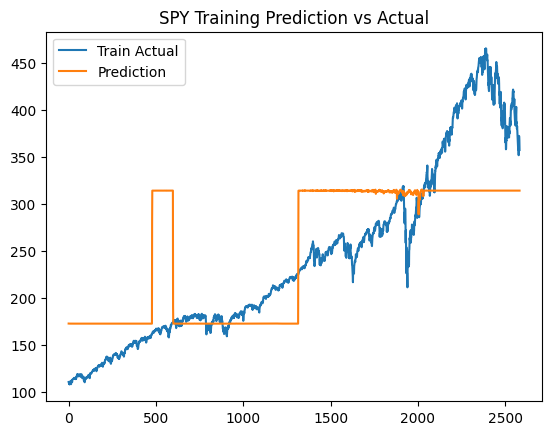

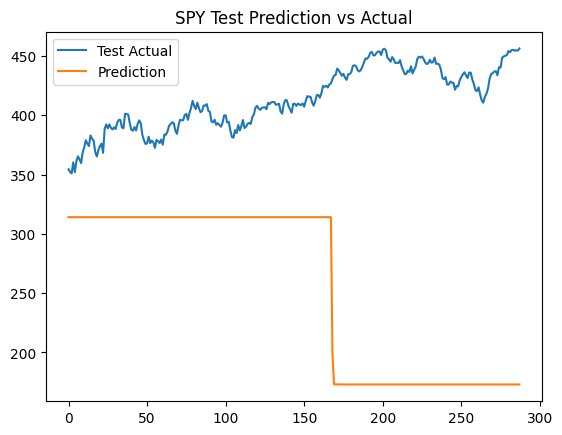

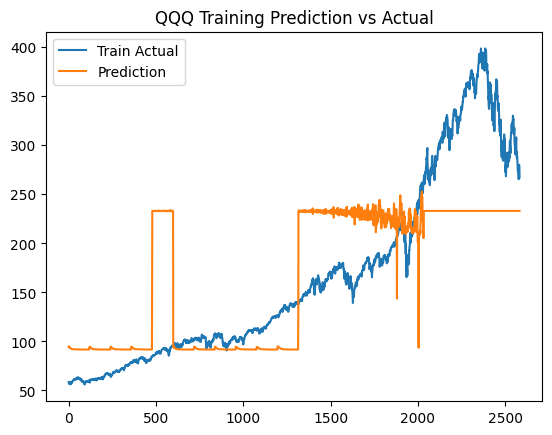

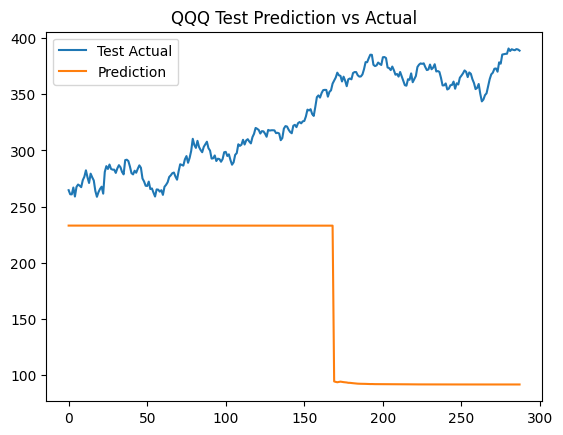

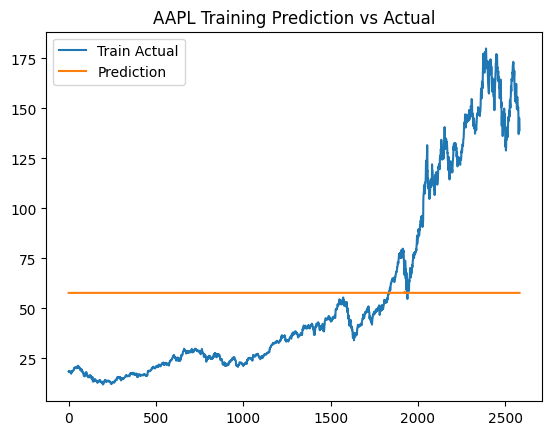

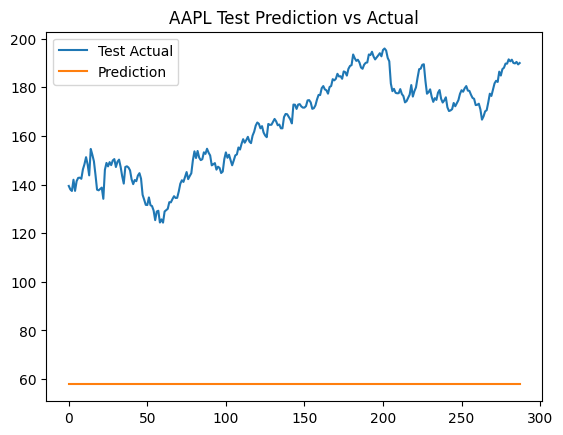

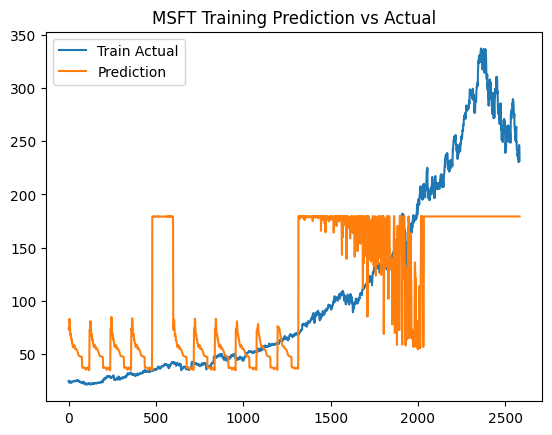

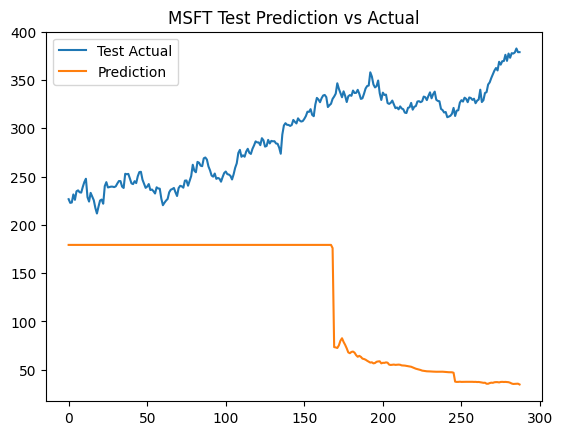

In [33]:
train(scaled_train_test)

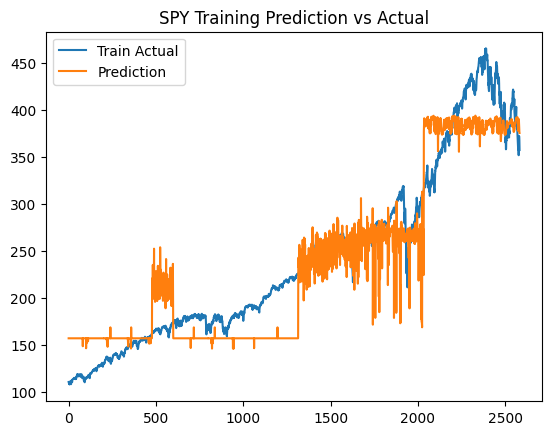

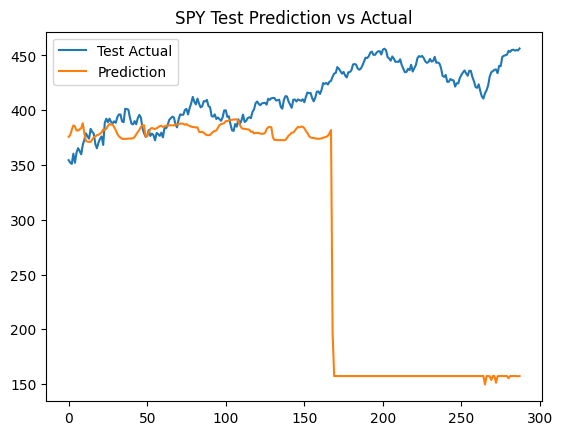

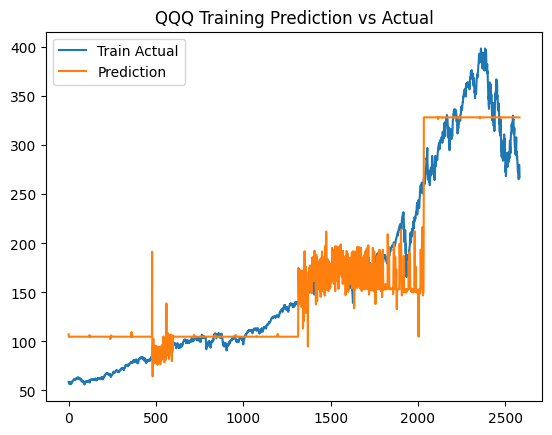

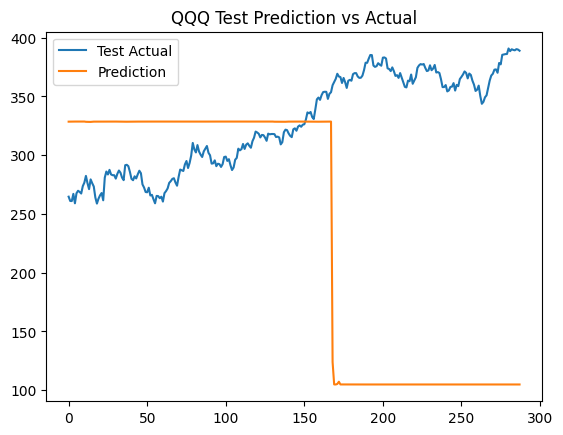

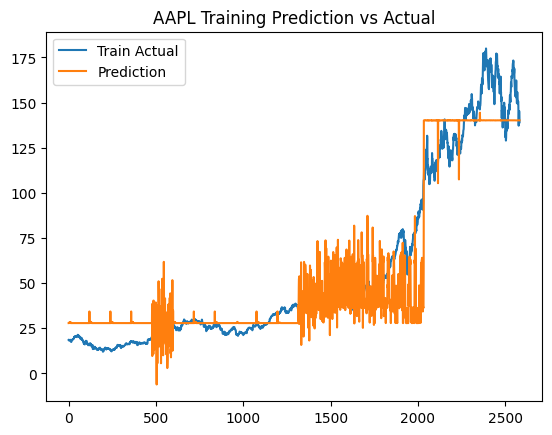

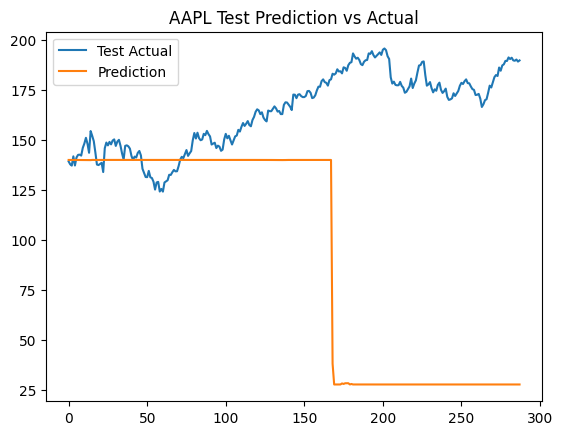

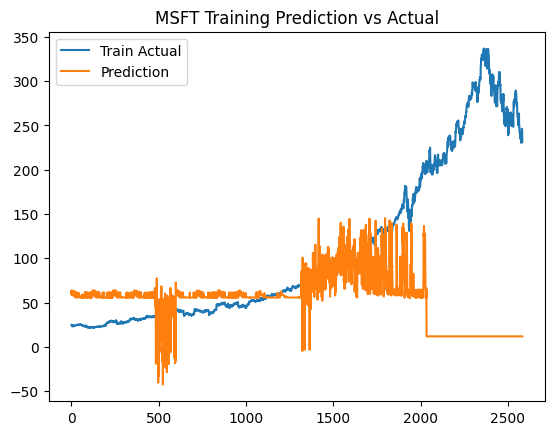

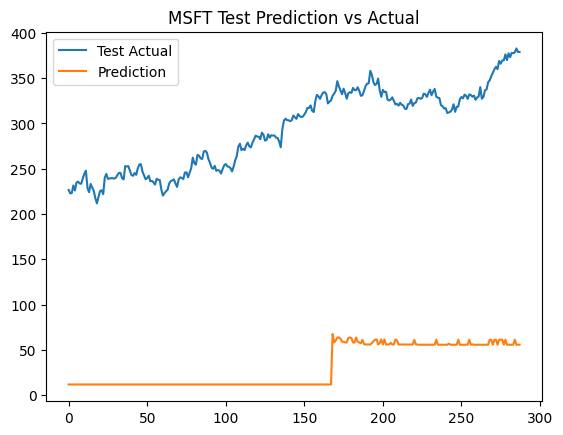

In [34]:
train(train_test)

In [35]:
def plot_feature_distribution(train_test: dict[str, tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]], data_set_index: int, data_set_name: str) -> None:
    for ticker, data_set in train_test.items():
        plt.figure(figsize=(10, 6))
        plt.title(f'{ticker} Features Distribution')

        for feature_index in range(data_set[data_set_index].shape[2]):
            plt.hist(data_set[data_set_index][:, :, feature_index].flatten(), bins=30, alpha=0.5, label=f'{data_set_name} Feature {feature_index}')

        plt.legend(loc='upper left', bbox_to_anchor=(1,1))
        plt.tight_layout()
        
        plt.show()

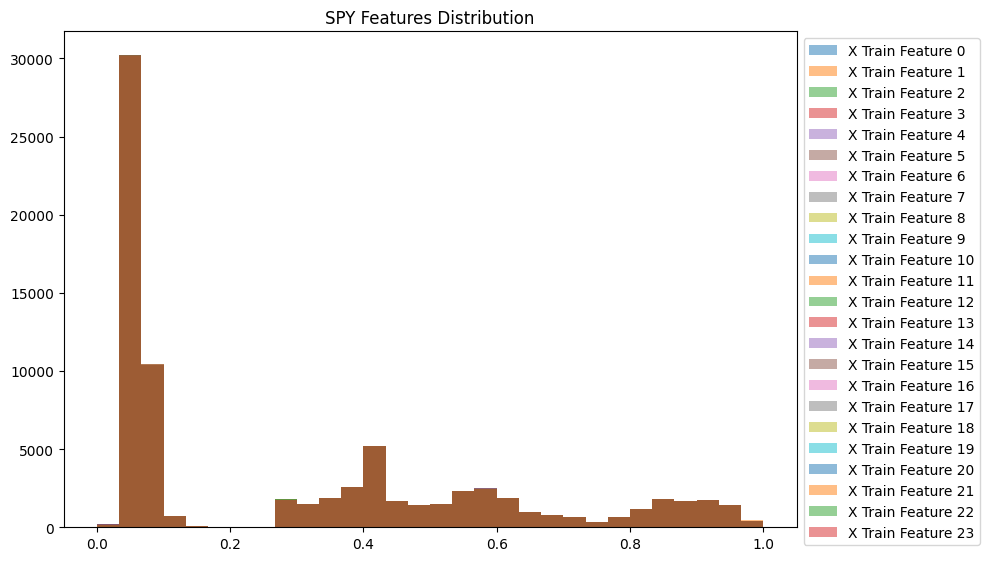

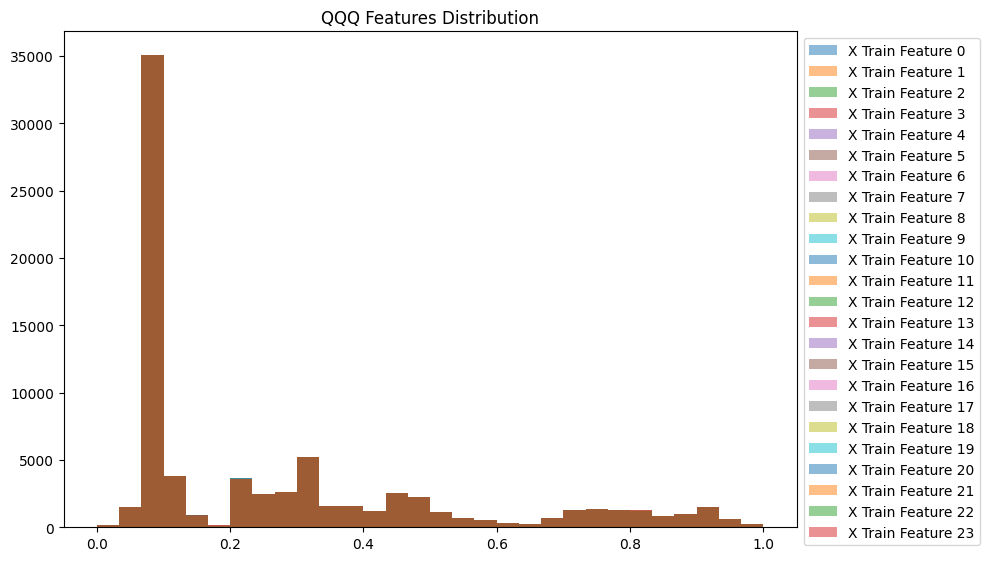

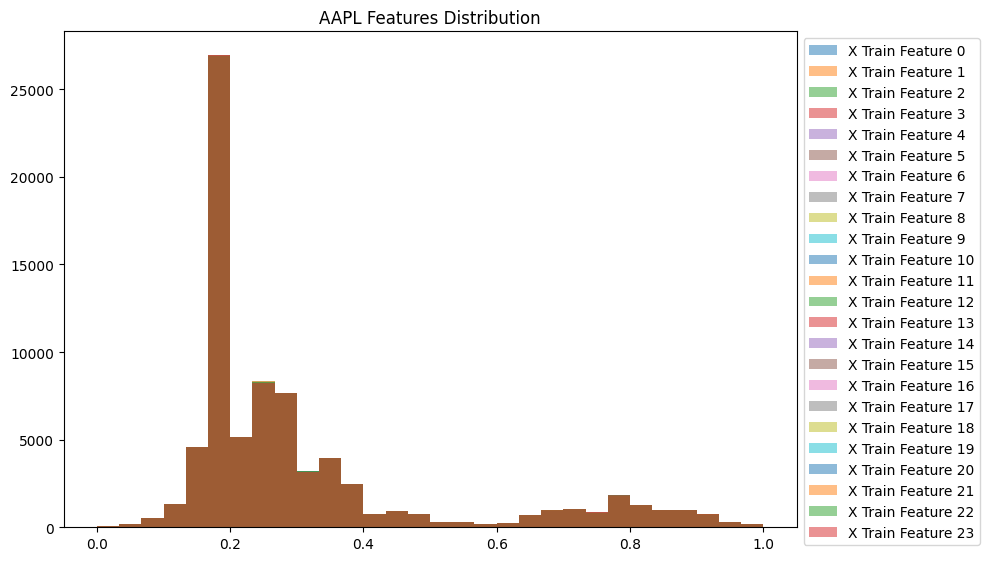

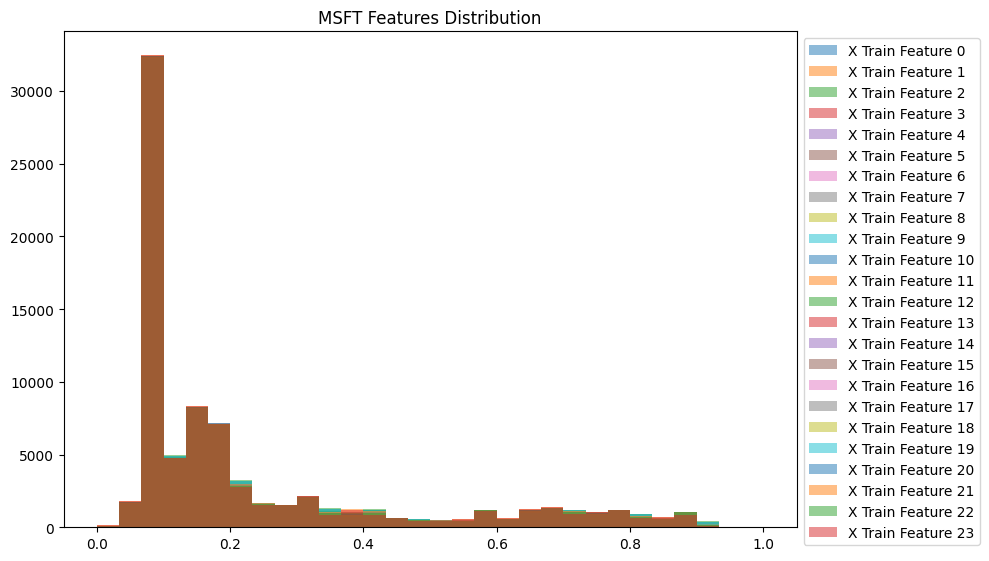

In [36]:
plot_feature_distribution(scaled_train_test, 0, 'X Train')

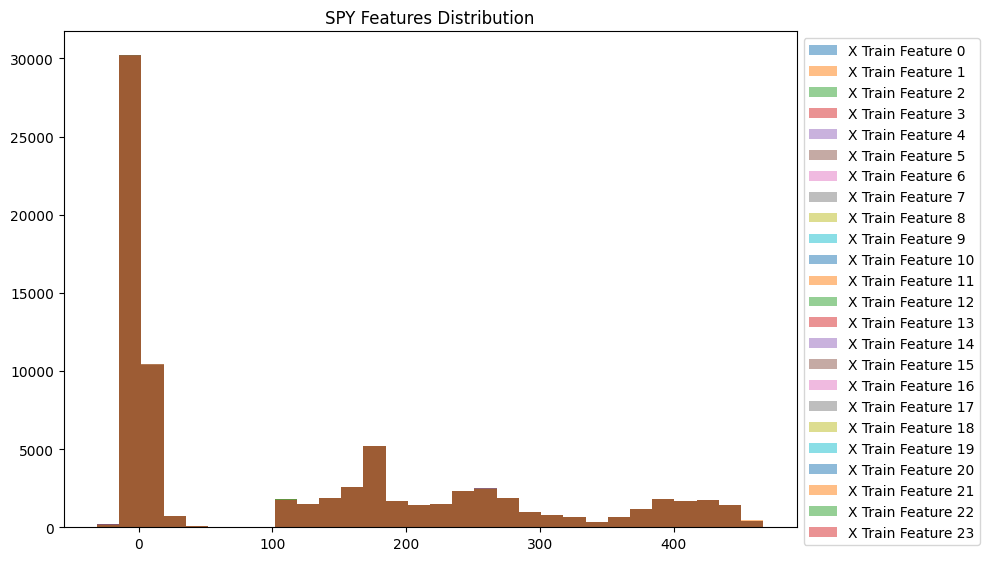

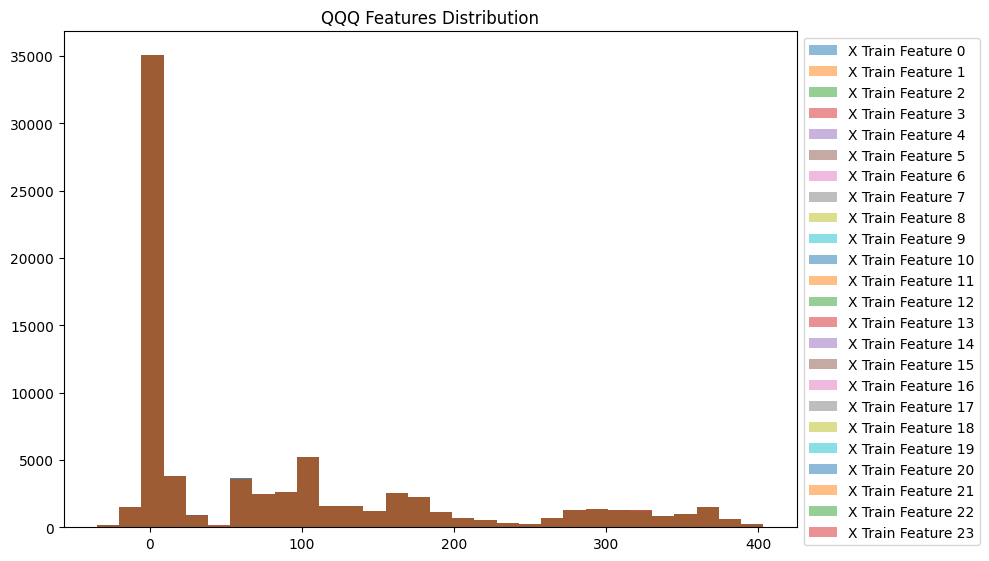

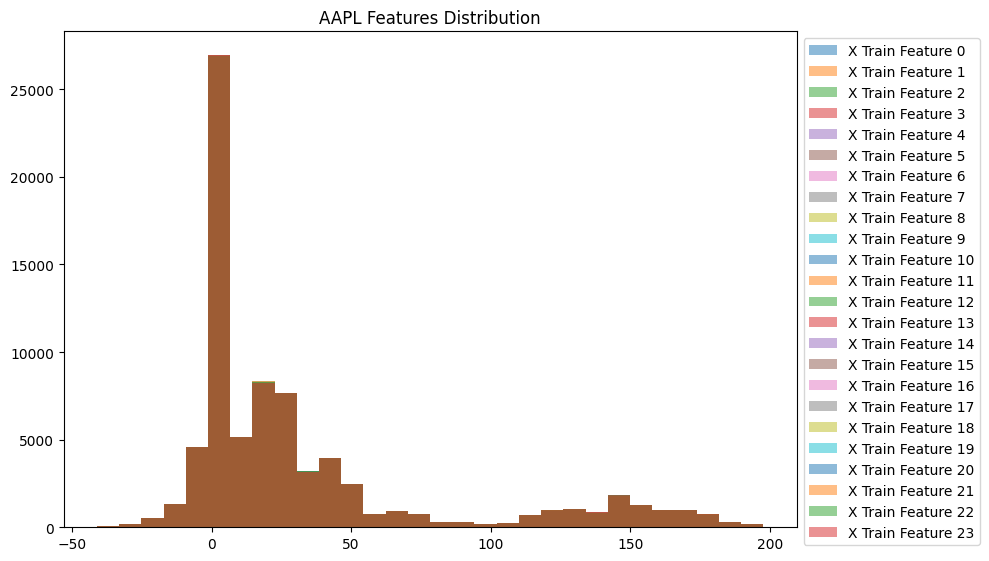

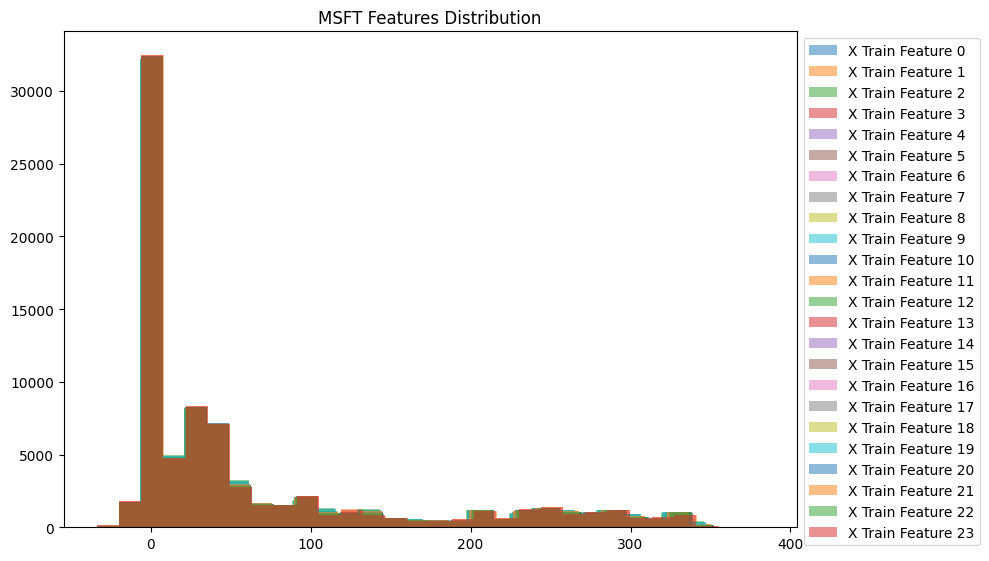

In [37]:
plot_feature_distribution(train_test, 0, 'X Train')

In [38]:
from sklearn.preprocessing import PowerTransformer


power_transformed_train_test = scale(PowerTransformer())
    

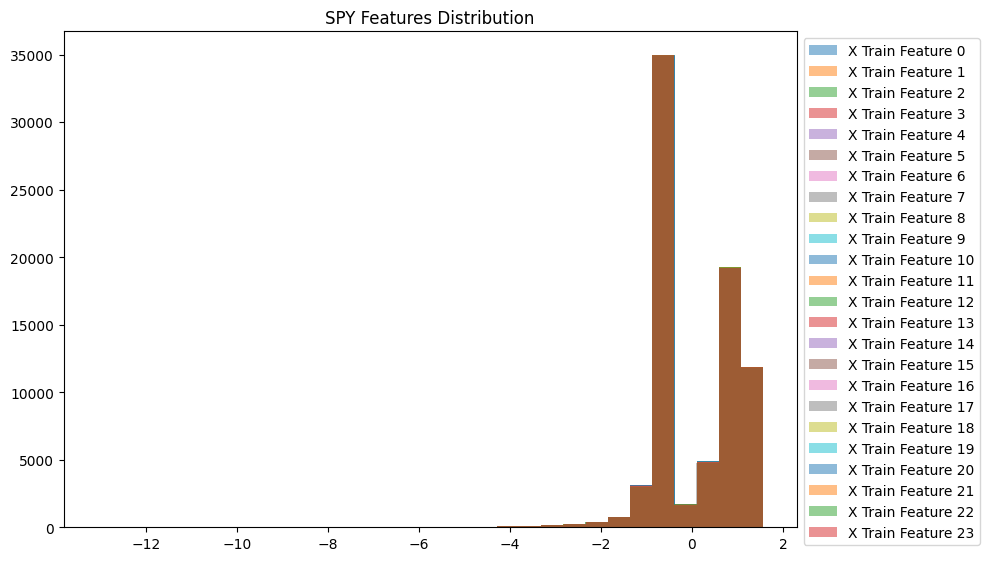

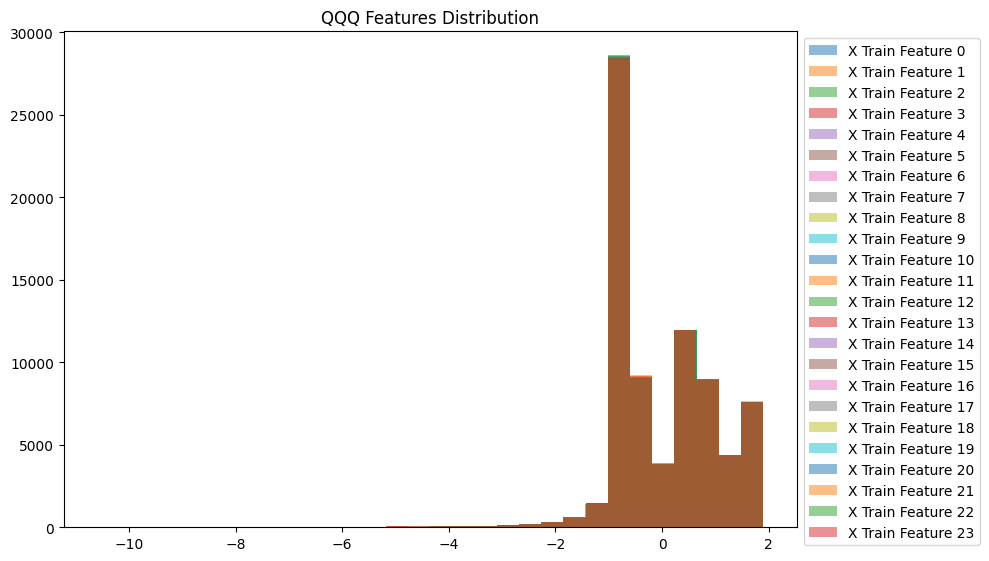

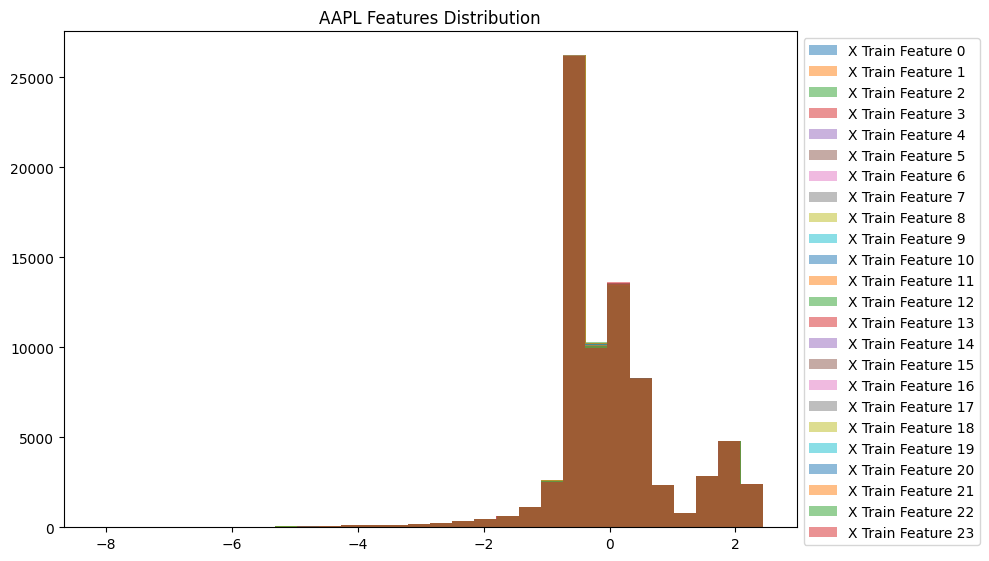

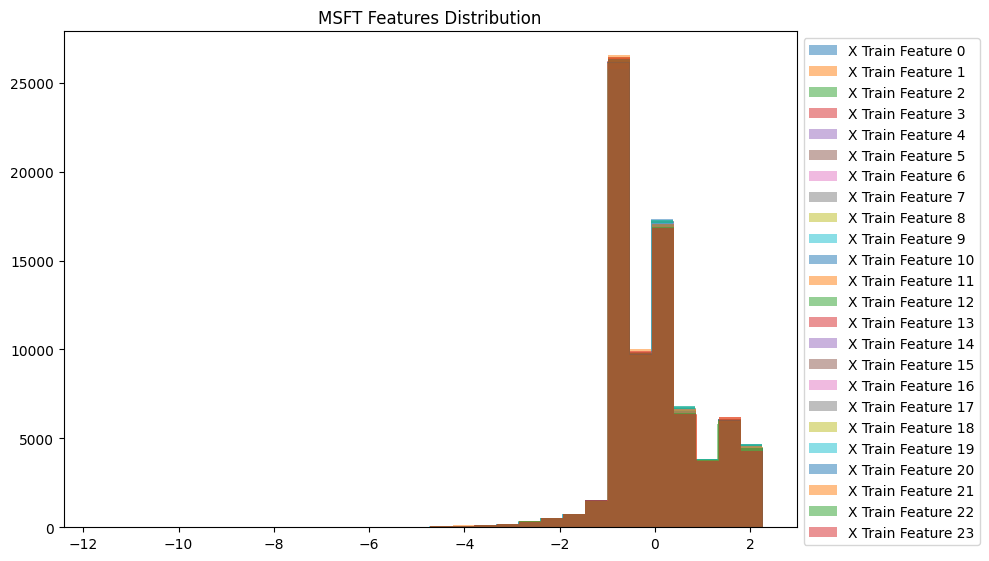

In [39]:
plot_feature_distribution(power_transformed_train_test, 0, 'X Train')

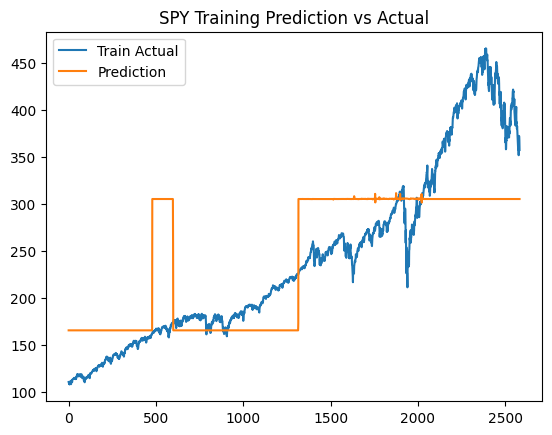

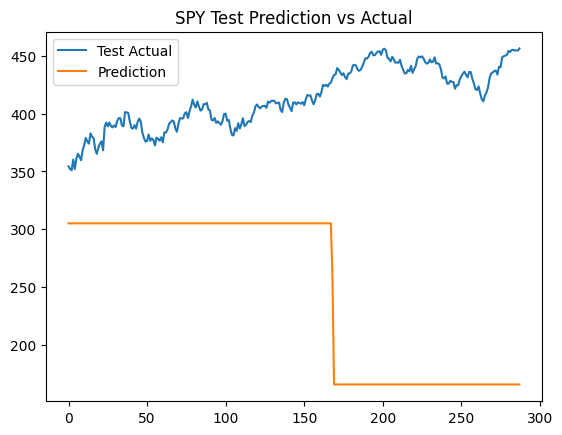

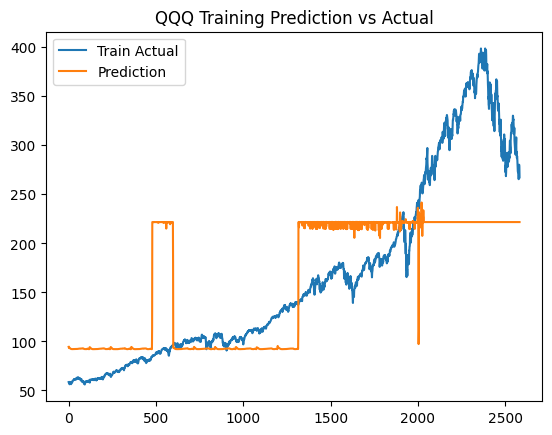

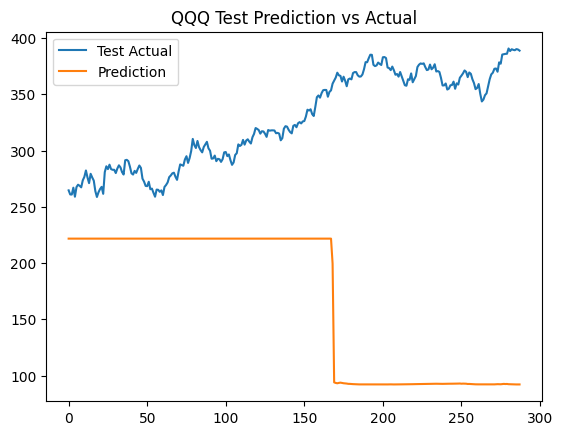

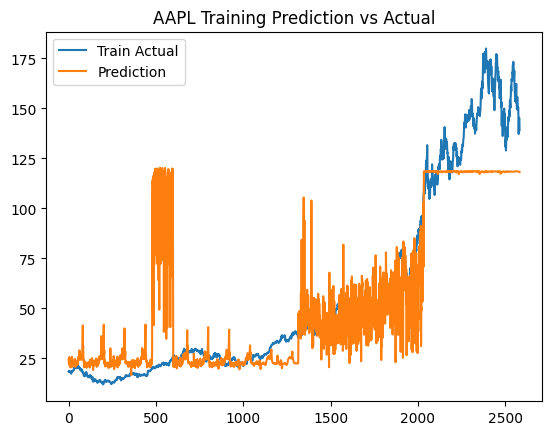

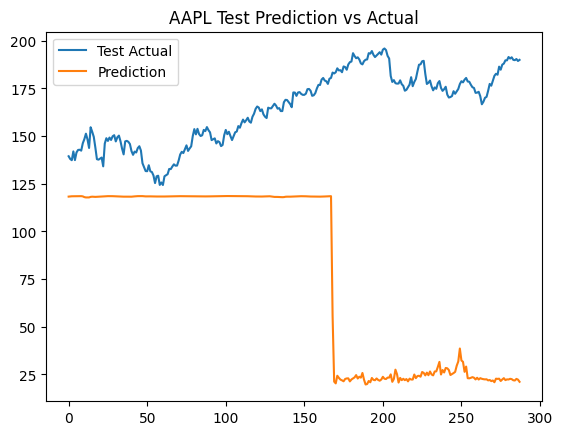

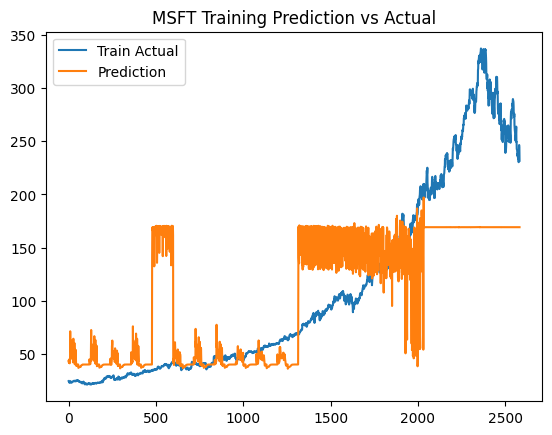

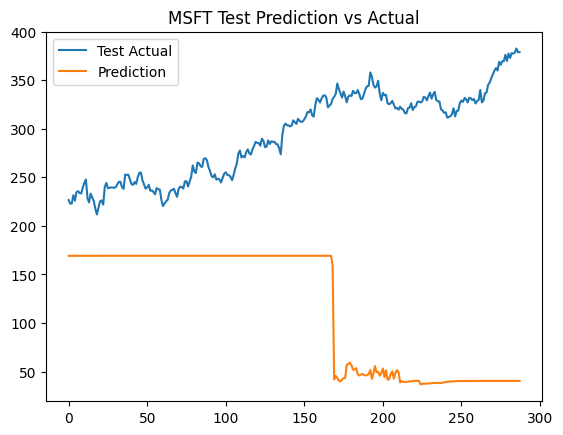

In [40]:
train(power_transformed_train_test)

In [41]:
from sklearn.preprocessing import QuantileTransformer


normal_quantile_transformed_train_test = scale(QuantileTransformer(output_distribution='normal', random_state=0))

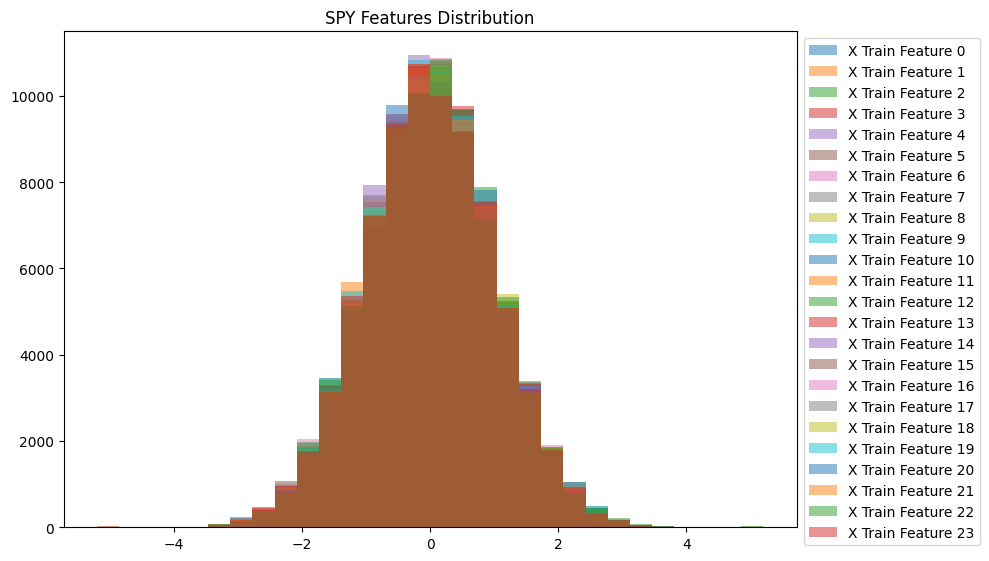

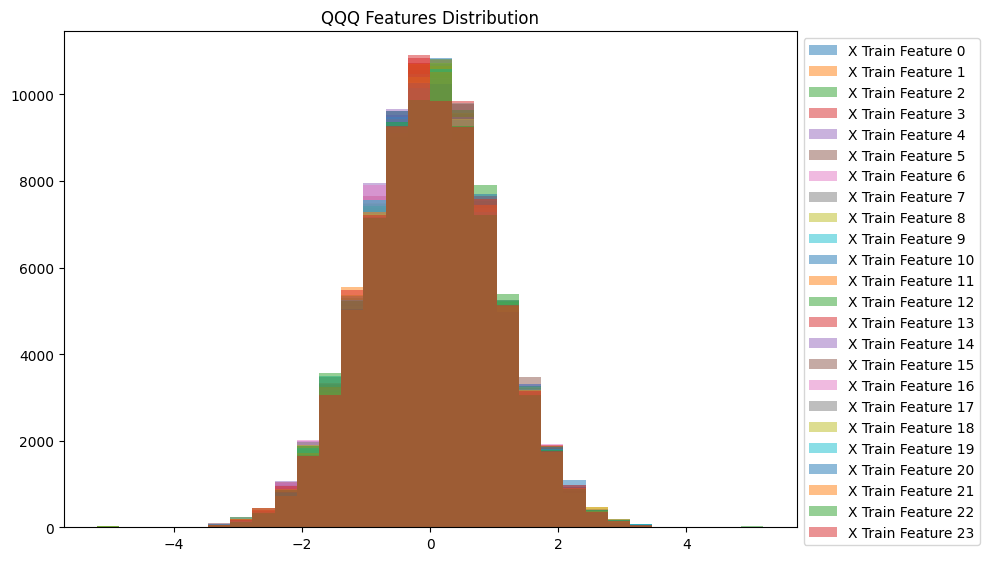

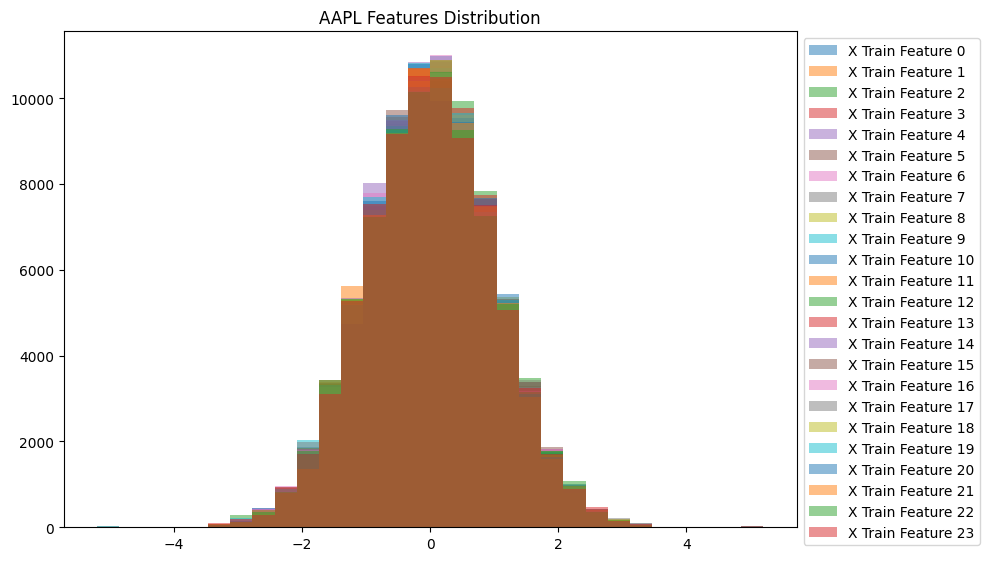

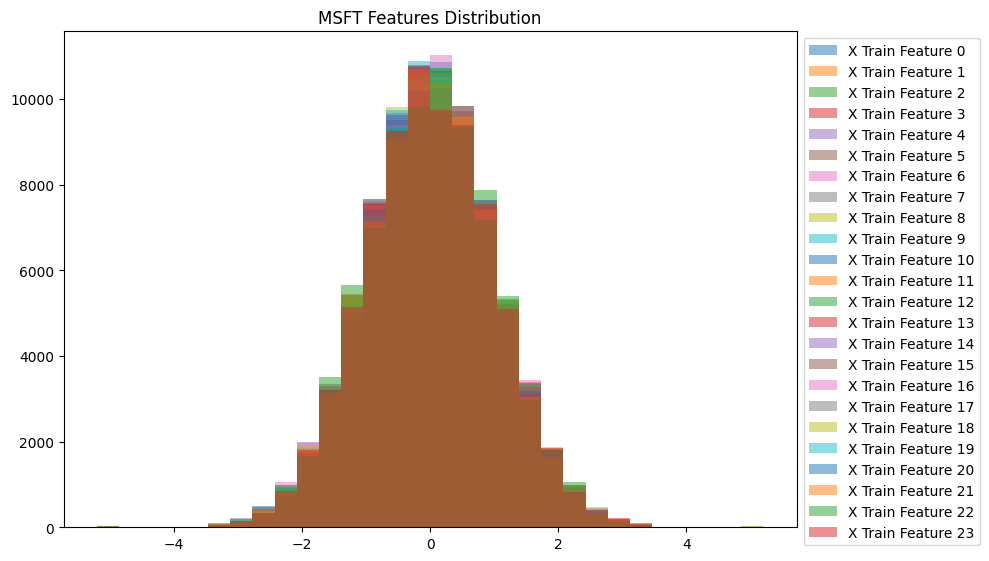

In [42]:
plot_feature_distribution(normal_quantile_transformed_train_test, 0, 'X Train')

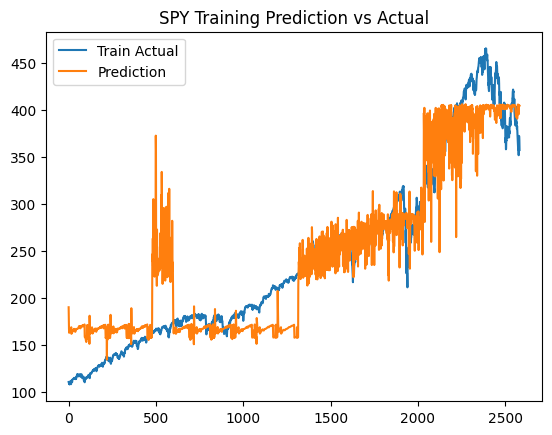

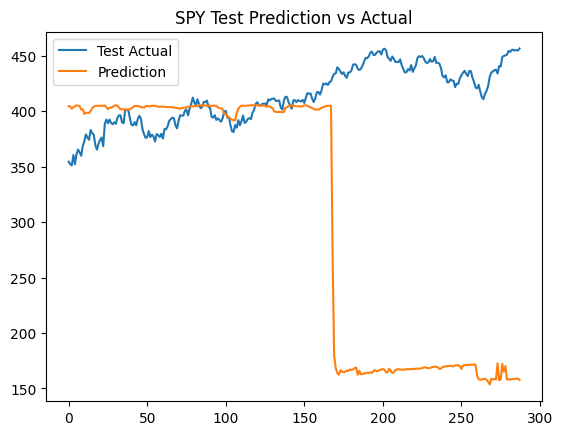

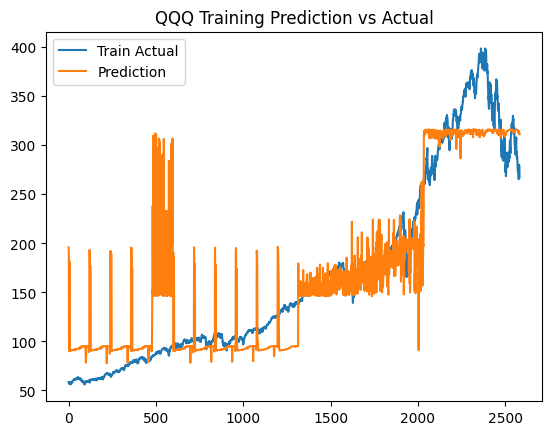

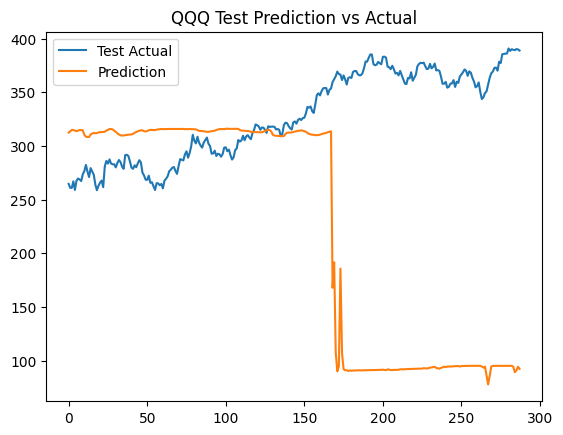

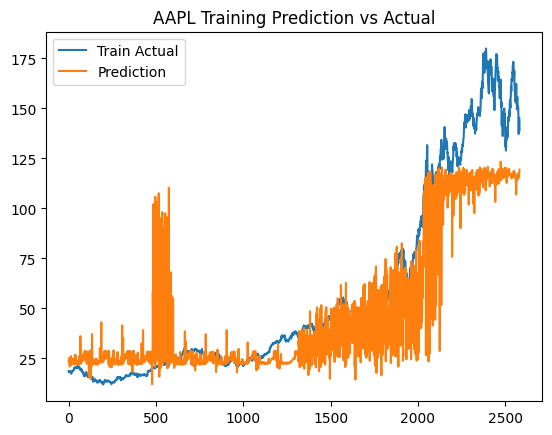

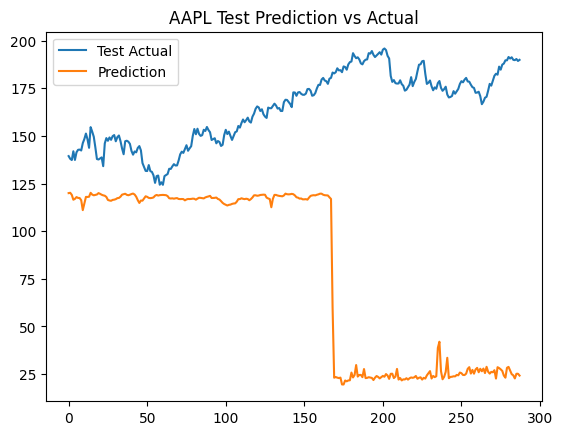

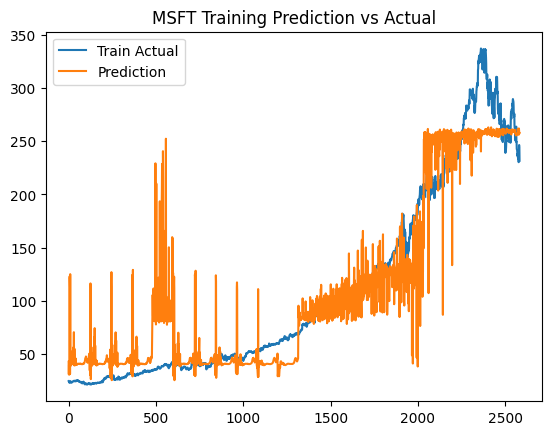

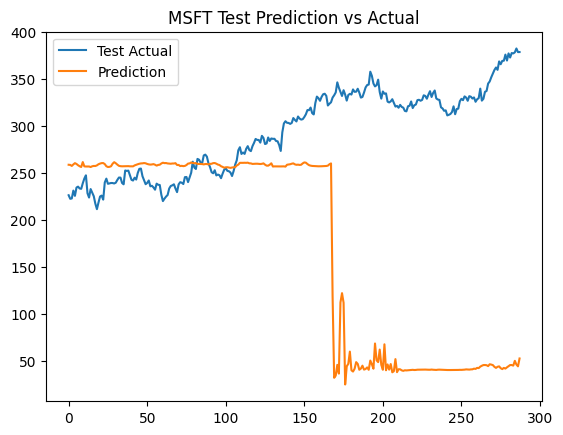

In [43]:
train(normal_quantile_transformed_train_test)

In [44]:
uniform_quantile_transformed_train_test = scale(QuantileTransformer(output_distribution='uniform', random_state=0))

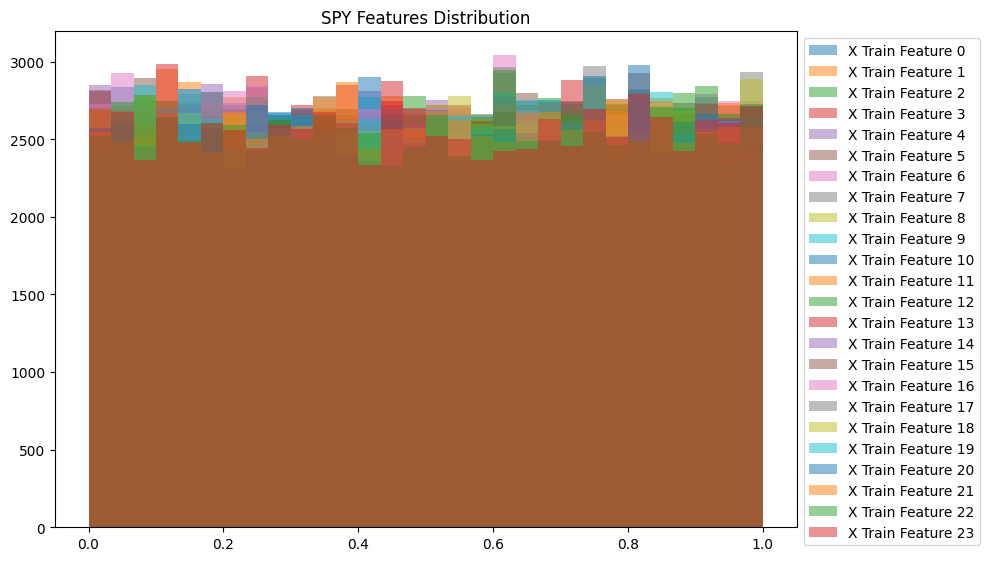

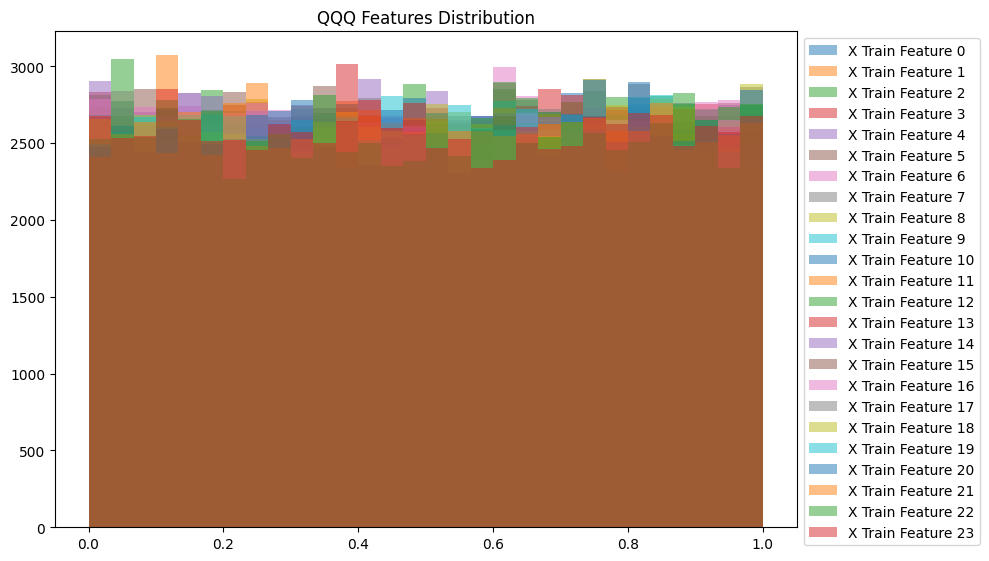

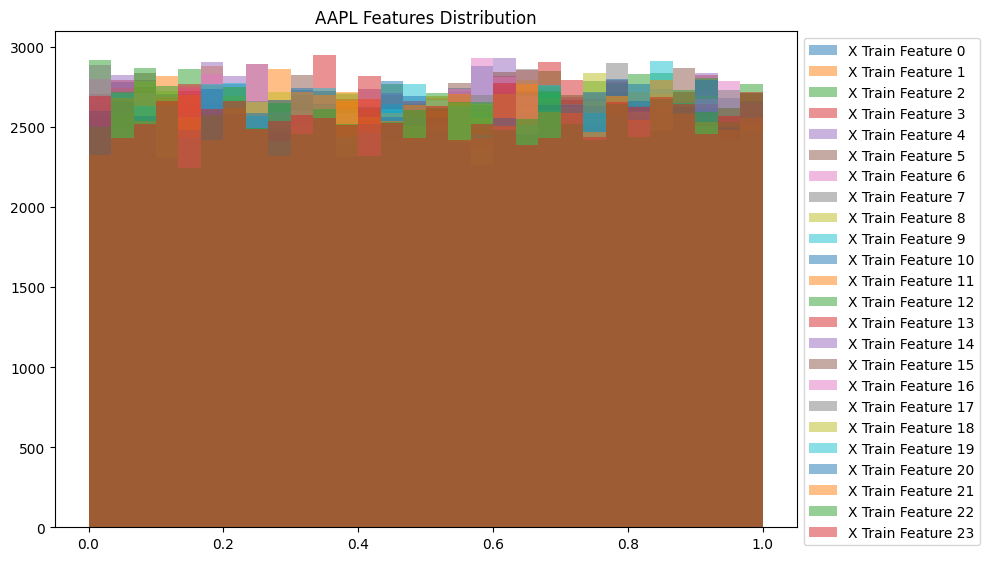

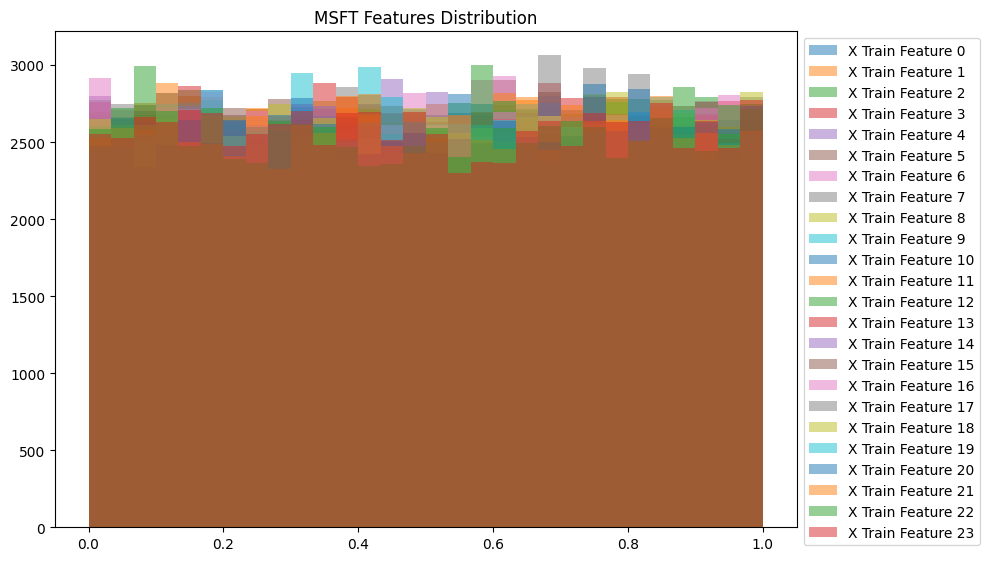

In [45]:
plot_feature_distribution(uniform_quantile_transformed_train_test, 0, 'X Train')

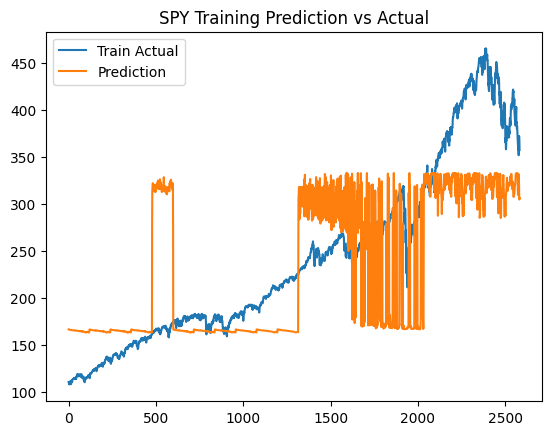

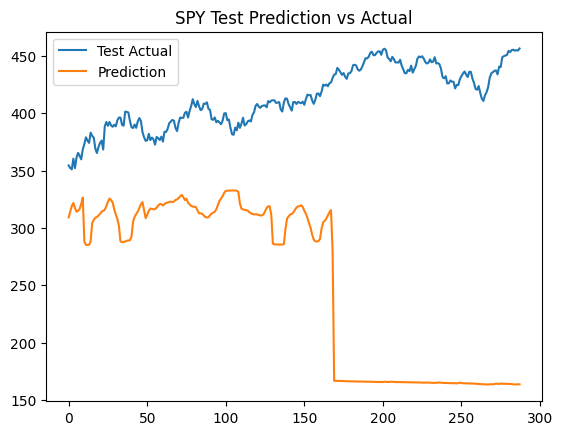

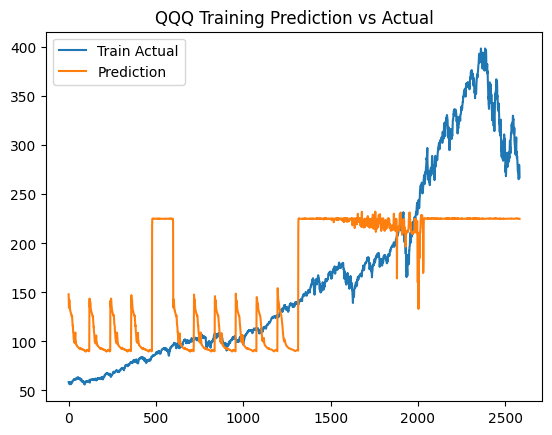

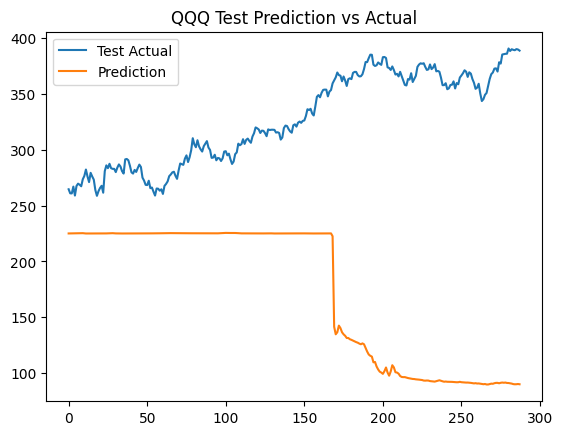

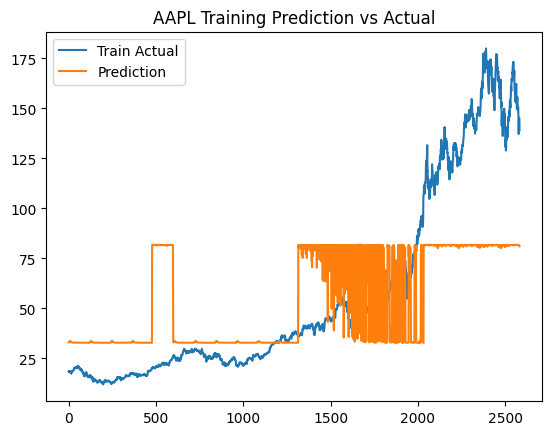

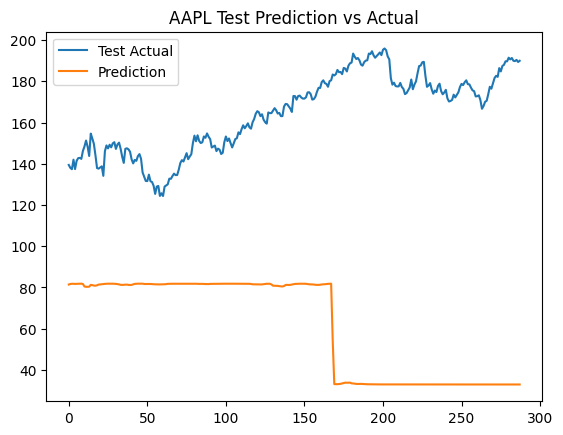

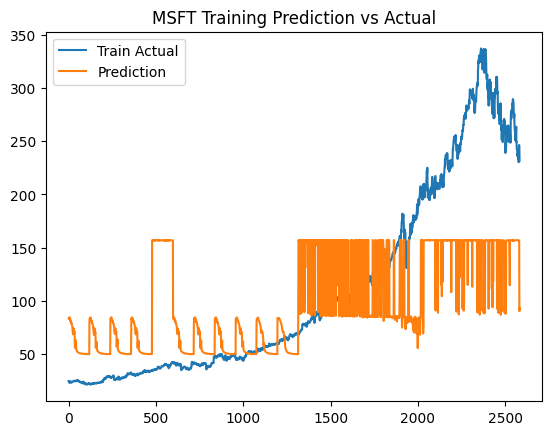

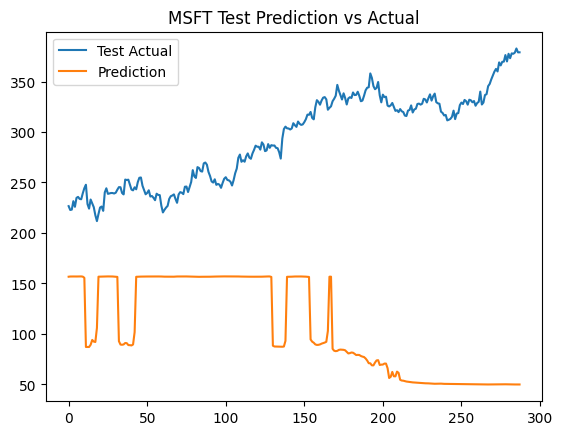

In [46]:
train(uniform_quantile_transformed_train_test)